In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from spectral_cube import SpectralCube
from astropy.modeling.functional_models import Gaussian1D
import regions
from NOEMAsetup import *
import pyspeckit
# Use only with regions!
from astropy.modeling import models



block_reduce was moved to the astropy.nddata.blocks module.  Please update your import statement.


### Important functions

In [2]:
def degtohoursRA(deg):
    hours = deg / 360 * 24
    hh = np.trunc(hours).astype('int64')

    minutes = ((hours-hh) % 60) * 60
    mm = np.trunc(minutes).astype('int64')
    seconds = ((minutes-mm) % 60) * 60
    ss = np.round(seconds, 2)
    return '{0:02d}:{1:02d}:{2:0>5}'.format(hh, mm, ss)


def degtohoursDEC(deg):
    dd = np.trunc(deg).astype('int64')
    minutes = ((np.abs(deg)-np.abs(dd)) % 60) * 60
    mm = np.trunc(minutes).astype('int64')
    seconds = ((minutes-mm) % 60) * 60
    ss = np.round(seconds, 2)
    return '{0:02d}:{1:02d}:{2:0>5}'.format(dd, mm, ss)


def plotSpectra(ax, vel, spec, color='k', freq=None, beamarea=None, xlims=None, ylims=None):
    if kelvin:
        spec = spec.to(u.K, u.brightness_temperature(freq, beam_area=beamarea))
    ax.plot(vel, spec, drawstyle='steps-mid', color=color)
    ax.set_xlabel('Velocity (km/s)')
    if kelvin:
        ax.set_ylabel('Intensity (K)')
    else:
        ax.set_ylabel('Intensity (Jy/beam)')

    if xlims is not None:
        ax.set_xlim(xlims)
    if ylims is not None:
        ax.set_ylim(ylims)
    return ax

def loadCube(filein):
    cube = SpectralCube.read(filein)
    cube = cube.with_spectral_unit(u.km/u.s)
    cube = cube.spectral_slab(velstart*u.km/u.s, velend*u.km/u.s)
    cubehead = cube.header
    bmaj = cubehead['bmaj'] * u.deg
    bmin = cubehead['bmin'] * u.deg
    beamarea = (1.133 * bmaj * bmin).to(u.arcsec**2)
    restfreq = cubehead['restfreq'] * u.Hz
    return cube, beamarea, restfreq
  
# TODO: refactor getting spectra to then do a plot of stacked spectra
def get_spectra(cube, position, velstart, velend):
    cubehead = cube.header
    bmaj = cubehead['bmaj'] * u.deg
    bmin = cubehead['bmin'] * u.deg
    beamarea = (1.133 * bmaj * bmin).to(u.arcsec**2)
    restfreq = cubehead['restfreq'] * u.Hz
    cubewcs = WCS(cubehead)
    ra, dec = cubewcs.celestial.all_world2pix(position[0], position[1], 0)
    rah = degtohoursRA(position[0])
    dech = degtohoursDEC(position[1])
    velocities = cube.spectral_axis
    intensities = cube[:, int(dec), int(ra)]
    return velocities, intensities

def get_parameters_spectra(paramcube, position, header):
    '''
    This function returns all the contents in the cube along the spectra. 
    This means it returns errors as well if the paramscube includes them
    '''
    cubewcs = WCS(header)
    ra, dec = cubewcs.celestial.all_world2pix(position[0], position[1], 0)
    params = paramcube[:, int(dec), int(ra)]
    return params


def plotSpectras(fig, position, fitsfiles, labels, colors, regionlabel, phasecenter, subplots=111, xlims=None, ylims=None, saving=False, specname=''):
    deltas = phasecent-position
    ax = fig.add_subplot(subplots)
    i = 0
    for fitsfile, label, color in zip(fitsfiles, labels, colors):
        if fitsfile is None:
            continue
        cube, beamarea, restfreq = loadCube(fitsfile+'.fits')
        velocities, spectra = get_spectra(cube, position, velstart, velend)
        if kelvin:
            ax = plotSpectra(ax, velocities, spectra, color=color, freq=restfreq, beamarea=beamarea, xlims=xlims, ylims=ylims)
        else:
            ax = plotSpectra(ax, velocities, spectra, color=color, xlims=xlims, ylims=ylims)
        ax.text(0.05, 0.9-0.09*i, label, horizontalalignment='left', transform=ax.transAxes, color=color, size=14)
        i += 1
    ax.text(0.05, 0.9-0.09*i, 'Region '+regionlabel, horizontalalignment='left', transform=ax.transAxes, color='k', size=14)
    if saving:
        fig.savefig(fitsfiles[0]+'_delta_'+str(np.round(deltas[0]*3600, 2))+'_' + str(
            np.round(-deltas[1]*3600, 2))+'_'+specname+'.png', bbox_inches='tight')
    return ax

def plotSpectrasGrid(fitsfile, regionsfile, xlims=None, ylims=None, color='k', figsize=None, saving=False, specname=''):
    regionload = regions.read_ds9(regionsfile)
    regionlabels = [regionload[i].meta['label'] for i in range(len(regionload))]
    positions = [[regionload[i].center.ra.value, regionload[i].center.dec.value] for i in range(len(regionload))]
    naxis = len(positions)
    
    cube, beamarea, restfreq = loadCube(fitsfile+'.fits')
    header = cube.header
    phasecent = [header['ra'], header['dec']]
    
    if figsize is not None:
      fig, axlist = plt.subplots(naxis, sharex=True, figsize=figsize) 
      
    else:
      fig, axlist = plt.subplots(naxis, sharex=True, figsize=(4,3*naxis))
        
    for position, label, ax in zip(positions, regionlabels, axlist):
      velocities, spectra = get_spectra(cube, position, velstart, velend)
      if kelvin:
        plotSpectra(ax, velocities, spectra, freq=restfreq, beamarea=beamarea, xlims=xlims, ylims=ylims)
      else:
        plotSpectra(ax, velocities, spectra, xlims=xlims, ylims=ylims)
      ax.text(0.05, 0.9, 'Region '+label, horizontalalignment='left', transform=ax.transAxes, color=color, size=14)
    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    if saving:
      fig.savefig(fitsfile+specname+'.png', bbox_inches='tight')
    return fig
    
                     




## Spectra with one line

In [ ]:
# Spectra from regions in SO 55-44
saveaction = 0
kelvin = 0
namecomparison = 'SO_auxregions'
label1 = r'SO($5_5 - 4_4$)'

folder = 'SO_55_44/CDconfig/'
fitsfile = SO_55_44

regfile = folder+'spectra_aux_reg2.reg'
fitsfilelist = [fitsfile]
labellist = [label1]
colorlist = ['k']

velstart = -1
velend = 15

intmin = -0.05
intmax = 0.155 # Jy.beam
# intmin = -5
# intmax = 30 # K

header = fits.getheader(fitsfile+'.fits')
phasecent = np.array([header['ra'], header['dec']])
regionload = regions.read_ds9(regfile)
positions = [[regionload[i].center.ra.value, regionload[i].center.dec.value]
             for i in range(len(regionload))]
regionlabels = [regionload[i].meta['label'] for i in range(len(regionload))]


for position, regionlabel in zip(positions, regionlabels):
    '''
    For each region in the list, plot
    '''
    fig = plt.figure(figsize=(6,4))
    plotSpectras(fig, position, fitsfilelist, labellist, colorlist, regionlabel, phasecent,
                 xlims=[velstart, velend], ylims=[intmin, intmax], saving=saveaction, specname=namecomparison+'_reg'+regionlabel)
    plt.show()


### Spectra from SO gaussian fitting

Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.


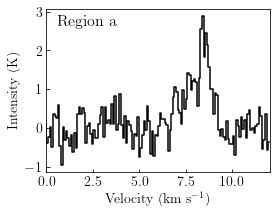

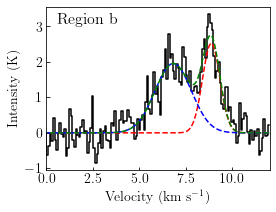

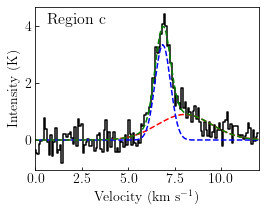

In [29]:
# Plot with fit 2G

saveaction = 1
folder = 'SO_55_44/CDconfigsmall/'
cubefile = folder+'Per-emb-50_CD_l009l048_uvsub_SO_multi_small'
velstart = 0
velend = 12
cube, beamarea, restref = loadCube(cubefile+'_fitcube2g.fits')
paramscube = fits.getdata(cubefile + '_2G_fitparams.fits')
header = cube.header
regfile = 'SO_55_44/CDconfig/spectra_aux_reg2.reg'
phasecent = np.array([header['ra'], header['dec']])
regionload = regions.read_ds9(regfile)
positions = [[regionload[i].center.ra.value, regionload[i].center.dec.value]
             for i in range(len(regionload))]
regionlabels = [regionload[i].meta['label'] for i in range(len(regionload))]

for position, regionlabel in zip(positions, regionlabels):
    '''
    For each region in the list, plot
    '''
    vel, spec = get_spectra(cube, position, velstart, velend)
    params = get_parameters_spectra(paramscube, position, header)
    g1 = models.Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])
    g2 = models.Gaussian1D(amplitude=params[3], mean=params[4], stddev=params[5])
    
    fig = plt.figure(figsize=(4,3))
    
    ax = fig.add_subplot(111)
    ax.plot(vel, spec, drawstyle='steps-mid', color='k')
    ax.plot(vel, g1(vel.value), 'r--')
    ax.plot(vel, g2(vel.value), 'b--')
    ax.plot(vel, g1(vel.value)+g2(vel.value), 'g--')
    ax.set_xlabel(r'Velocity (km s$^{-1}$)')
    ax.set_ylabel('Intensity (K)')
    ax.set_xlim([velstart, velend])
    ax.text(0.05,0.9, 'Region '+regionlabel, horizontalalignment='left', transform=ax.transAxes, color='k', size=16)
    if saveaction:
      fig.savefig(folder+'2G_fit_result_region'+regionlabel+'.pdf', dpi=300, bbox_inches='tight')

Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.


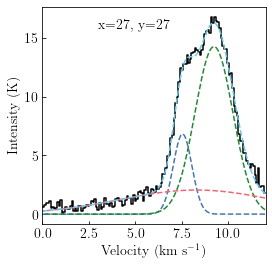

In [22]:
# Plot with fit 3G
# Here we plot from positions in the sky, not from regions

saveaction = 1
folder = 'SO_55_44/CDconfigsmall/gaussian_fit_123G_fitcube2g/'
cubefile = folder+'Per-emb-50_CD_l009l048_uvsub_SO_multi_small'
savefile = cubefile+'_sample_3G_streamer_27_27_center.pdf'
pixels = 'x=27, y=27'
velstart = 0
velend = 12
cube, beamarea, restref = loadCube(cubefile+'_fitcube2g.fits')
paramscube = fits.getdata(cubefile + '_3G_fitparams_aicres.fits')
#using the aicres makes sure that if it is not the best fit, it does not appear
header = cube.header
wcscel = WCS(header).celestial
phasecent = np.array([header['ra'], header['dec']])
# x, y = wcscel.all_world2pix([52.2811874],[31.3641355],0)
# spectra = cube[:,int(y[0]),int(x[0])]
position = wcscel.all_pix2world(27,27,0)
# position = [52.2821095,31.3654869]

vel, spec = get_spectra(cube, position, velstart, velend)
params = get_parameters_spectra(paramscube, position, header)

spec = spec.to(u.K)

params = get_parameters_spectra(paramscube, position, header)
g1 = models.Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])
g2 = models.Gaussian1D(amplitude=params[3], mean=params[4], stddev=params[5])
g3 = models.Gaussian1D(amplitude=params[6], mean=params[7], stddev=params[8])

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(vel, spec, drawstyle='steps-mid', color='k')
ax.plot(vel, g1(vel.value), color='#4477aa', linestyle='dashed')
ax.plot(vel, g2(vel.value), color='#228833', linestyle='dashed')
ax.plot(vel, g3(vel.value), color='#ee6677', linestyle='dashed')
ax.plot(vel, g1(vel.value)+g2(vel.value)+g3(vel.value), color='#66ccee', linestyle='dashed')
# ax.plot(vel, g1(vel.value)+g2(vel.value), color='#66ccee', linestyle='dashed')
ax.set_xlabel(r'Velocity (km s$^{-1}$)')
ax.set_ylabel('Intensity (K)')
ax.set_xlim([velstart, velend])
ax.annotate(pixels, (0.25,0.9),xycoords='axes fraction',fontsize=14)

if saveaction:
  fig.savefig(savefile, dpi=300, bbox_inches='tight')


SO spectra in the kink, fitted

This function (<function BaseSpectralCube.to at 0x7f87e914e820>) requires loading the entire cube into memory and may therefore be slow.


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,139 [pyspeckit.spectrum.interactive]


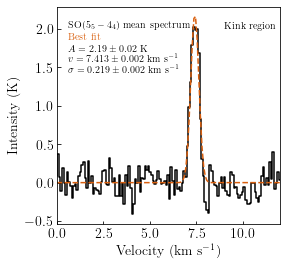

In [33]:
# Plot the mean  of the kink in SO with fit 1G
# Here we plot from positions in the sky



saveaction = 1
folder = 'SO_55_44/CDconfigsmall/'
cubefile = folder+'Per-emb-50_CD_l009l048_uvsub_SO_multi_small'
savefile = cubefile+'_sample_1G_streamer_meankink.pdf'
velstart = 0
velend = 12
cube, beamarea, restref = loadCube(cubefile+'.fits')
paramscube = fits.getdata(cubefile + '_1G_streamer.fits')
header = cube.header
wcscel = WCS(header).celestial
phasecent = np.array([header['ra'], header['dec']])
rms = (12.94 * u.mJy/u.beam).to(u.K, u.brightness_temperature(restref, beam_area=beamarea))
vel = cube.spectral_axis
centersky = SkyCoord(52.2809646,31.3648169,unit='deg',frame='fk5')

# this is the mean parameters from each pixel
regmean = regions.CircleSkyRegion(center=centersky, radius=0.0004718 * u.deg)
mask = np.repeat([regmean.to_pixel(wcscel).to_mask().to_image(np.shape(paramscube[0]))], 6, axis=0)
subparams = np.where(mask, paramscube, np.nan)
meanparams = [np.nanmean(subparams[0]), np.nanmean(subparams[1]),np.nanmean(subparams[2])]
# The previous mask is circular, but we need to select where the parameters are not nan.
mask2 = np.where(np.isnan(subparams[0]),0,1) 
subcube = cube.with_mask(np.repeat([mask2],len(vel),axis=0))

spec = np.nanmean(subcube.to(u.K).filled_data[:,:,:], axis=(1, 2))  
rmsspec = rms/np.sqrt(np.sum(mask2)) * np.ones(np.shape(spec))

# We calculate the gaussian that fits the mean spectra best 
sp = pyspeckit.Spectrum(data=spec, error=rmsspec, xarr=cube.spectral_axis)
sp.specfit(fittype='gaussian',guesses=meanparams)
paramsfit = sp.specfit.get_model(vel)

modelparams = sp.specfit.modelpars
modelerror = sp.specfit.modelerrs

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(vel, spec, drawstyle='steps-mid', color='k',label=r'SO($5_5-4_4$)')
ax.plot(vel, paramsfit, color='#d95f0e', linestyle='dashed', label='Best fit')
ax.set_xlabel(r'Velocity (km s$^{-1}$)')
ax.set_ylabel('Intensity (K)')
ax.set_xlim([velstart, velend])
ax.annotate(r'SO($5_5-4_4$) mean spectrum', (0.05,0.9),xycoords='axes fraction',fontsize=10)
ax.annotate(r'Best fit', (0.05,0.85),xycoords='axes fraction',fontsize=10,color='#d95f0e')
ax.annotate('Kink region', (0.75,0.9),xycoords='axes fraction',fontsize=10)
ax.annotate(r'$A=' + str(np.round(modelparams[0],2)) + r'\pm'+ str(np.round(modelerror[0],2))+'$ K', (0.05,0.8), xycoords='axes fraction',fontsize=10)
ax.annotate(r'$v=' + str(np.round(modelparams[1],3)) + r'\pm'+ str(np.round(modelerror[1],3))+r'$ km s$^{-1}$', (0.05,0.75), xycoords='axes fraction',fontsize=10)
ax.annotate(r'$\sigma=' + str(np.round(modelparams[2],3)) + r'\pm'+ str(np.round(modelerror[2],3))+r'$ km s$^{-1}$', (0.05,0.7), xycoords='axes fraction',fontsize=10)


if saveaction:
  fig.savefig(savefile, dpi=300, bbox_inches='tight')

In [ ]:
# Plot of C18O from position in the sky
saveaction = 0
folder = 'ALMA/'
filename = folder+'Per50_H2COa_natural_noSC_clean'
cube = SpectralCube.read(filename+'.fits').with_spectral_unit(u.km/u.s, velocity_convention='radio')
wcscel = cube.wcs.celestial
x, y = wcscel.all_world2pix([52.2811874],[31.3641355],0)
spectra = cube[:,int(y[0]),int(x[0])]
vel = cube.spectral_axis.value

savefile = filename+'_sample_spectra.pdf'

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(vel,spectra,drawstyle='steps-mid', color='k')
ax.set_xlabel(r'$v_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'Intensity (Jy beam$^{-1}$)')
ax.set_xlim([5.5,9])
ax.annotate(r'\textbf{H\boldmath$_{2}$CO($3_{0,3}-2_{0,2}$)}',(0.6,0.9), xycoords='axes fraction', color='k', size=14)

if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)

### Spectra from SO2, fitted

Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.


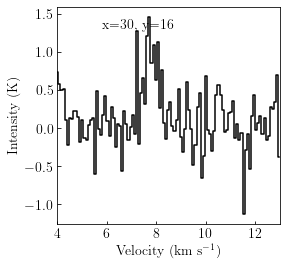

In [28]:
# Plot with fit 2G
# Here we plot from positions in the sky, not from regions

saveaction = 0
folder = 'SO2_11_1_11_10_0_10/CDconfig/'
cubefile = folder+'Per-emb-50_CD_l031l070_uvsub_SO2_multi'
pixelx = 30
pixely = 16
savefile = cubefile+'_sample_2G_streamer_{0}_{1}_center.pdf'.format(pixelx, pixely)
pixels = 'x={0}, y={1}'.format(pixelx, pixely)
velstart = 4
velend = 13
cube, beamarea, restref = loadCube(cubefile+'_fitcube2g.fits')
paramscube = fits.getdata(cubefile + '_2G_fitparams_aicres.fits')
#using the aicres makes sure that if it is not the best fit, it does not appear
header = cube.header
wcscel = WCS(header).celestial
phasecent = np.array([header['ra'], header['dec']])
position = wcscel.all_pix2world(pixelx,pixely,0)

vel, spec = get_spectra(cube, position, velstart, velend)
params = get_parameters_spectra(paramscube, position, header)

spec = spec.to(u.K)

params = get_parameters_spectra(paramscube, position, header)
g1 = models.Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])
g2 = models.Gaussian1D(amplitude=params[3], mean=params[4], stddev=params[5])

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(vel, spec, drawstyle='steps-mid', color='k')
ax.plot(vel, g1(vel.value), color='#4477aa', linestyle='dashed')
ax.plot(vel, g2(vel.value), color='#228833', linestyle='dashed')
ax.plot(vel, g1(vel.value)+g2(vel.value), color='#cc0000', linestyle='dashed')
ax.set_xlabel(r'Velocity (km s$^{-1}$)')
ax.set_ylabel('Intensity (K)')
ax.set_xlim([velstart, velend])
ax.annotate(pixels, (0.2,0.9),xycoords='axes fraction',fontsize=14)

if saveaction:
  fig.savefig(savefile, dpi=300, bbox_inches='tight')

## Spectra with two lines

H2CO v/s SO(55-44)

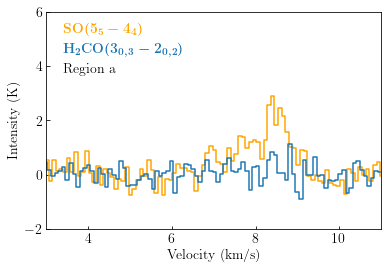

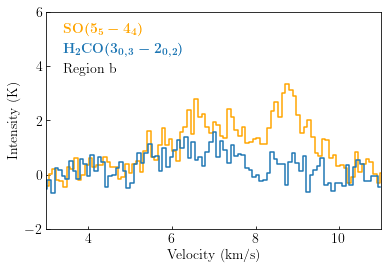

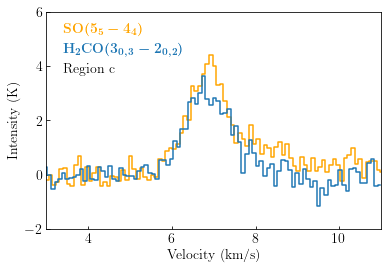

In [4]:
saveaction = 0
kelvin = 1
namecomparison = 'H2CO_SO5544'
label1 = r'\textbf{SO\boldmath{$(5_5 - 4_4)$}}'
label2 = r'\textbf{H\boldmath{$_2$}CO(\boldmath{$3_{0,3} - 2_{0,2})$}}'

folder = 'SO_55_44/CDconfig/'
fitsfile = SO_55_44
fitsfile2 = H2CO_303_202

regfile = folder+'spectra_aux_reg2.reg'
fitsfilelist = [fitsfile, fitsfile2]
labellist = [label1, label2]
colorlist = ['orange', 'C0']

velstart = 3
velend = 11

# intmin = -0.05
# intmax = 0.16 # Jy.beam
intmin = -2
intmax = 6 # K

header = fits.getheader(fitsfile+'.fits')
phasecent = np.array([header['ra'], header['dec']])
regionload = regions.read_ds9(regfile)
positions = [[regionload[i].center.ra.value, regionload[i].center.dec.value] for i in range(len(regionload))]
regionlabels = [regionload[i].meta['label'] for i in range(len(regionload))]


for position, regionlabel in zip(positions, regionlabels):
    '''
    For each region in the list, plot
    '''
    fig = plt.figure(figsize=(6,4))
    plotSpectras(fig, position, fitsfilelist, labellist, colorlist, regionlabel, phasecent,
                 xlims=[velstart, velend], ylims=[intmin, intmax], saving=saveaction, specname=namecomparison+'_reg'+regionlabel)
    plt.show()


H2CO vs C18O

Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.


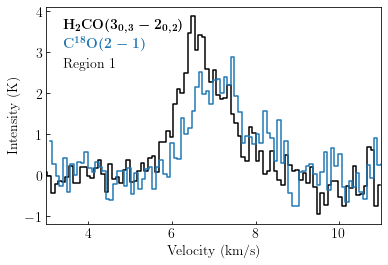

Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.


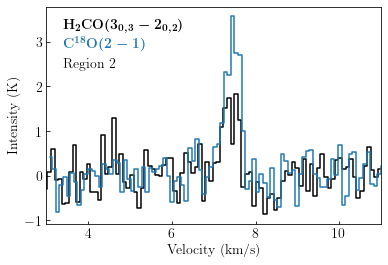

Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.


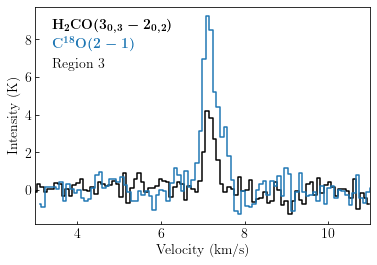

Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.


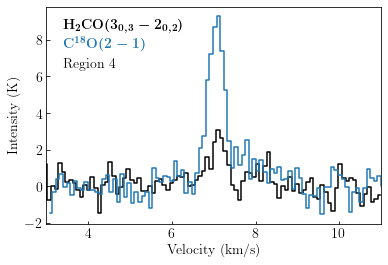

Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.


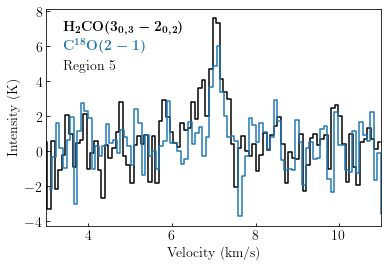

Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.


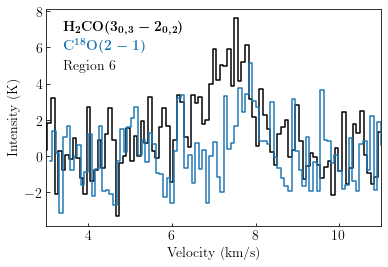

In [10]:
saveaction = 0
kelvin = 1
namecomparison = 'H2CO_C18O'
label1 = r'\textbf{H\boldmath{$_2$}CO(\boldmath{$3_{0,3} - 2_{0,2})$}}'
label2 = r'\textbf{C\boldmath{$^{18}$}O($2-1$)}'

folder = 'H2CO/CDconfig/'
fitsfile = H2CO_303_202 + '_pbcor'
fitsfile2 = C18O_2_1 + '_pbcor'

regfile = folder+'spectra_regs.reg'
fitsfilelist = [fitsfile, fitsfile2]
labellist = [label1, label2]
colorlist = ['k', 'C0']

velstart = 3
velend = 11

# intmin = -0.05
# intmax = 0.16 # Jy.beam
intmin = -2
intmax = 6 # K

header = fits.getheader(fitsfile+'.fits')
phasecent = np.array([header['ra'], header['dec']])
regionload = regions.read_ds9(regfile)
positions = [[regionload[i].center.ra.value, regionload[i].center.dec.value] for i in range(len(regionload))]
regionlabels = [regionload[i].meta['label'] for i in range(len(regionload))]


for position, regionlabel in zip(positions, regionlabels):
    '''
    For each region in the list, plot
    '''
    fig = plt.figure(figsize=(6,4))
    plotSpectras(fig, position, fitsfilelist, labellist, colorlist, regionlabel, phasecent,
                 xlims=[velstart, velend], saving=saveaction, specname=namecomparison+'_reg'+regionlabel)
    plt.show()

## Stacked spectra

### SO(55-44)


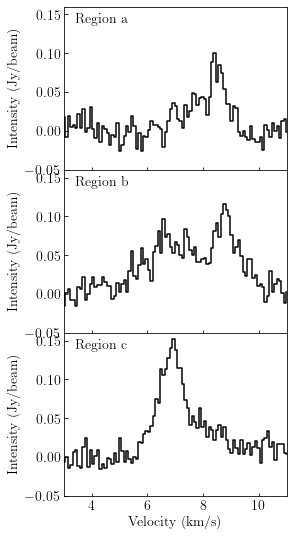

In [5]:
saveaction = 0
kelvin = 0

folder = 'SO_55_44/CDconfig/'
fitsfile = SO_55_44

regfile = folder+'spectra_aux_reg2.reg'
velstart = 3
velend = 11
intmin = -0.05
intmax = 0.16 # Jy/beam

fig = plotSpectrasGrid(fitsfile, regfile, xlims=[velstart, velend], ylims=[intmin, intmax])

In [ ]:
cubefile = 'SO_55_44/CDconfigsmall/Per-emb-50_CD_l009l048_uvsub_SO_multi_small'
spc = pyspeckit.Cube(cubefile+'_fitcube2g.fits')
spc.load_model_fit(cubefile + '_2G_fitparams.fits', 3, npeaks=2, fittype='gaussian')
paramscube = spc.parcube
errcube = scp.errcube


### H2CO

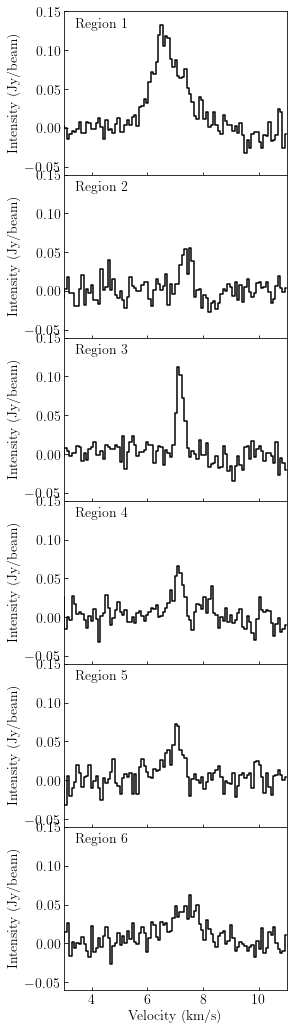

In [6]:
saveaction = 1
kelvin = 0

folder = 'H2CO/CDconfig/'
fitsfile = H2CO_303_202
nameplot = 'streamerregions'

regfile = folder+'spectra_regs.reg'
velstart = 3
velend = 11
intmin = -0.06
intmax = 0.15 # Jy/beam

fig = plotSpectrasGrid(fitsfile, regfile, xlims=[velstart, velend], ylims=[intmin, intmax], saving=saveaction, specname=nameplot)